# SPECIES PREDICTION MODEL PIPELINE (Decision tree)

## Imports

In [1]:
import numpy as np 
import pandas as pd

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

# for vizualizing DT
from sklearn.tree import export_graphviz 
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

In [2]:
df = pd.read_csv("../species_prediction_model/data/field_big.csv")
df.head()

,watershed,river,site,method,local,water_temp_start,fork_length_mm,species
0,englishman,center creek,center creek,smolt trap,in-river,10.2,85.0,co
1,englishman,center creek,center creek,smolt trap,in-river,10.2,85.0,co
2,englishman,center creek,center creek,smolt trap,in-river,10.2,85.0,co
3,englishman,center creek,center creek,smolt trap,in-river,10.2,86.0,co
4,englishman,center creek,center creek,smolt trap,in-river,10.2,87.0,co


In [3]:
df.isnull().sum()

watershed               0
river                   0
site                    0
method               2431
local                2901
water_temp_start    22583
fork_length_mm        145
species                56
dtype: int64

In [4]:
#df= df.drop(['weight_g'], axis = 1)
df = df.dropna()

In [5]:
df.species.unique()

array(['co', 'rbt', 'stl', 'ct', 'bt', 'ck', 'cm'], dtype=object)

In [6]:
for col in df.columns:
    if col not in ['tag_id_long','fork_length_mm', 'water_temp_start']:
        print(col, ":", df[col].unique())

watershed : ['englishman' 'cowichan' 'nanaimo' 'puntledge']
river : ['center creek' 'shelly creek' 'cowichan' 'englishman' 'nanaimo'
 'puntledge' 'tsolum' 'haslam creek']
site : ['center creek' 'martindale rd' '70.2' 'skutz' 'side channel'
 'hamilton ave' 'cow bay' 'jack point' 'above tsolum' 'little mexico'
 'mainstem fence' 'newcastle' 'cedar bridge' 'living forest' 'vimy pool'
 'snuneymuxw beach' 'condensory bridge' 'tsolum confluence' 'tsolum'
 't-bone road']
method : ['smolt trap' 'beach seine' 'rst' 'g-trap']
local : ['in-river' 'marine']
species : ['co' 'rbt' 'stl' 'ct' 'bt' 'ck' 'cm']


In [7]:
# df= df.drop(['weight_g'], axis = 1)
# df = df.dropna()

In [8]:
fish_features = pd.read_csv("../species_prediction_model/data/fish_features.csv", index_col=None)
fish_features

,species,eye_size,snout_shape,parr_marks,parr_marks_length,spotting_density,fin_type
0,ck,large,pointy,slightly faded,long,medium,anal fin
1,co,large,short and blunt,slightly faded,long,medium,anal fin
2,cm,medium,NaN,faded,short,medium,caudal fin
3,pink,medium,NaN,NaN,NaN,NaN,caudal fin
4,so,very large,NaN,slightly faded,irregular,NaN,caudal fin
5,stl,small,short and rounded,faded,short,high,caudal fin
6,ct,small,long and pointy,faded,short,high,caudal fin
7,rbt,small,short and rounded,NaN,short,high,caudal fin


In [9]:
full = df.merge(fish_features, how='left',on='species')
full.head()

,watershed,river,site,method,local,water_temp_start,fork_length_mm,species,eye_size,snout_shape,parr_marks,parr_marks_length,spotting_density,fin_type
0,englishman,center creek,center creek,smolt trap,in-river,10.2,85.0,co,large,short and blunt,slightly faded,long,medium,anal fin
1,englishman,center creek,center creek,smolt trap,in-river,10.2,85.0,co,large,short and blunt,slightly faded,long,medium,anal fin
2,englishman,center creek,center creek,smolt trap,in-river,10.2,85.0,co,large,short and blunt,slightly faded,long,medium,anal fin
3,englishman,center creek,center creek,smolt trap,in-river,10.2,86.0,co,large,short and blunt,slightly faded,long,medium,anal fin
4,englishman,center creek,center creek,smolt trap,in-river,10.2,87.0,co,large,short and blunt,slightly faded,long,medium,anal fin


In [10]:
full = full.replace(np.nan, None)

In [11]:
full.isnull().sum()

watershed              0
river                  0
site                   0
method                 0
local                  0
water_temp_start       0
fork_length_mm         0
species                0
eye_size              76
snout_shape           86
parr_marks           525
parr_marks_length     76
spotting_density      76
fin_type              76
dtype: int64

In [12]:
full['species'].value_counts()

species
ck     19745
co     16607
stl      479
ct       479
rbt      449
bt        76
cm        10
Name: count, dtype: int64

In [13]:
# reducing the size of "full": co and ck will have 500 rows, rest all take as it is
co_sampled = full[full['species'] == 'co'].sample(n=500, random_state=42)
ck_sampled = full[full['species'] == 'ck'].sample(n=500, random_state=42)

In [14]:
labels_to_filter = ['stl', 'ct', 'rbt', 'cm']
others_combined = full[full['species'].isin(labels_to_filter)]
others_combined['species'].value_counts()

species
stl    479
ct     479
rbt    449
cm      10
Name: count, dtype: int64

In [15]:
full_small = pd.concat([co_sampled, ck_sampled, others_combined], axis=0)
full_small = full_small.reset_index(drop=True)

In [16]:
full_small['species'].value_counts()

species
co     500
ck     500
stl    479
ct     479
rbt    449
cm      10
Name: count, dtype: int64

In [17]:
full_small

,watershed,river,site,method,local,water_temp_start,fork_length_mm,species,eye_size,snout_shape,parr_marks,parr_marks_length,spotting_density,fin_type
0,nanaimo,nanaimo,cedar bridge,rst,in-river,10.7,105.0,co,large,short and blunt,slightly faded,long,medium,anal fin
1,englishman,center creek,center creek,smolt trap,in-river,14.1,90.0,co,large,short and blunt,slightly faded,long,medium,anal fin
2,englishman,shelly creek,martindale rd,smolt trap,in-river,12.9,95.0,co,large,short and blunt,slightly faded,long,medium,anal fin
3,englishman,shelly creek,martindale rd,smolt trap,in-river,10.8,102.0,co,large,short and blunt,slightly faded,long,medium,anal fin
4,englishman,center creek,center creek,smolt trap,in-river,11.0,81.0,co,large,short and blunt,slightly faded,long,medium,anal fin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2412,cowichan,cowichan,70.2,smolt trap,in-river,14.2,108.0,rbt,small,short and rounded,None,short,high,caudal fin
2413,cowichan,cowichan,70.2,smolt trap,in-river,14.2,120.0,rbt,small,short and rounded,None,short,high,caudal fin
2414,cowichan,cowichan,70.2,smolt trap,in-river,14.2,138.0,rbt,small,short and rounded,None,short,high,caudal fin
2415,cowichan,cowichan,70.2,smolt trap,in-river,12.5,93.0,rbt,small,short and rounded,None,short,high,caudal fin


## Pipeline 

### Pre-processing for the model

In [18]:
X = full_small.drop('species', axis = 1)
y = full_small['species']

In [19]:
# numeric_feats = [""]  # apply scaling
categorical_feats = ["watershed", "river", "site", "method", "local", "eye_size", "snout_shape", "parr_marks", 
                     "parr_marks_length", "spotting_density", "fin_type"]  # apply one-hot encoding
passthrough_feats = ["fork_length_mm"]  # do not apply any transformation
# drop_feats = [ "species" ]  
# levels = ["", ""]

In [20]:
ct = make_column_transformer (    
    #(StandardScaler(), numeric_feats),  
    ("passthrough", passthrough_feats),     
    (OneHotEncoder(), categorical_feats),  
    #("drop", drop_feats), 
    #OrdinalEncoder(categories=[levels], dtype=int)
)

In [21]:
transformed = ct.fit_transform(X)

In [22]:
column_names = (
    # numeric_feats
    passthrough_feats    
    + ct.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
)
column_names

['fork_length_mm',
 'watershed_cowichan',
 'watershed_englishman',
 'watershed_nanaimo',
 'watershed_puntledge',
 'river_center creek',
 'river_cowichan',
 'river_englishman',
 'river_haslam creek',
 'river_nanaimo',
 'river_puntledge',
 'river_shelly creek',
 'site_70.2',
 'site_above tsolum',
 'site_cedar bridge',
 'site_center creek',
 'site_condensory bridge',
 'site_cow bay',
 'site_hamilton ave',
 'site_jack point',
 'site_little mexico',
 'site_living forest',
 'site_mainstem fence',
 'site_martindale rd',
 'site_newcastle',
 'site_side channel',
 'site_skutz',
 'site_t-bone road',
 'site_tsolum confluence',
 'site_vimy pool',
 'method_beach seine',
 'method_g-trap',
 'method_rst',
 'method_smolt trap',
 'local_in-river',
 'local_marine',
 'eye_size_large',
 'eye_size_medium',
 'eye_size_small',
 'snout_shape_long and pointy',
 'snout_shape_pointy',
 'snout_shape_short and blunt',
 'snout_shape_short and rounded',
 'snout_shape_None',
 'parr_marks_faded',
 'parr_marks_slightly f

In [23]:
transformed

<2417x53 sparse matrix of type '<class 'numpy.float64'>'
	with 29004 stored elements in Compressed Sparse Row format>

In [24]:
X_transformed = pd.DataFrame.sparse.from_spmatrix(transformed, columns=column_names)
X_transformed.head()

,fork_length_mm,watershed_cowichan,watershed_englishman,watershed_nanaimo,watershed_puntledge,river_center creek,river_cowichan,river_englishman,river_haslam creek,river_nanaimo,...,snout_shape_None,parr_marks_faded,parr_marks_slightly faded,parr_marks_None,parr_marks_length_long,parr_marks_length_short,spotting_density_high,spotting_density_medium,fin_type_anal fin,fin_type_caudal fin
0,105.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,90.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,95.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,102.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,81.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


### Dummy model (Baseline)

In [25]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_transformed, y)
dummy_clf.score(X_transformed, y)

0.2068680182043856

### Decision Tree

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'max_depth': randint(1, 10), #Change to 20 when the dataset is bigger, 20 overfits currently
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

random_search = RandomizedSearchCV(DecisionTreeClassifier(), 
                                   param_distributions=param_dist, 
                                   n_iter=100, cv=5, random_state=42)
random_search.fit(X_train, y_train)

print("Best parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

Best parameters:  {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 6}
Best Score:  1.0


In [28]:
decision_tree = DecisionTreeClassifier(
    max_depth = random_search.best_params_["max_depth"],
    min_samples_split = random_search.best_params_["min_samples_split"],
    min_samples_leaf = random_search.best_params_["min_samples_leaf"],
    random_state = 42)

decision_tree.fit(X_train, y_train)
print("Train accuracy:", decision_tree.score(X_train, y_train))

Train accuracy: 1.0


In [29]:
decision_tree

DecisionTreeClassifier(max_depth=7, min_samples_leaf=4, min_samples_split=6,
                       random_state=42)

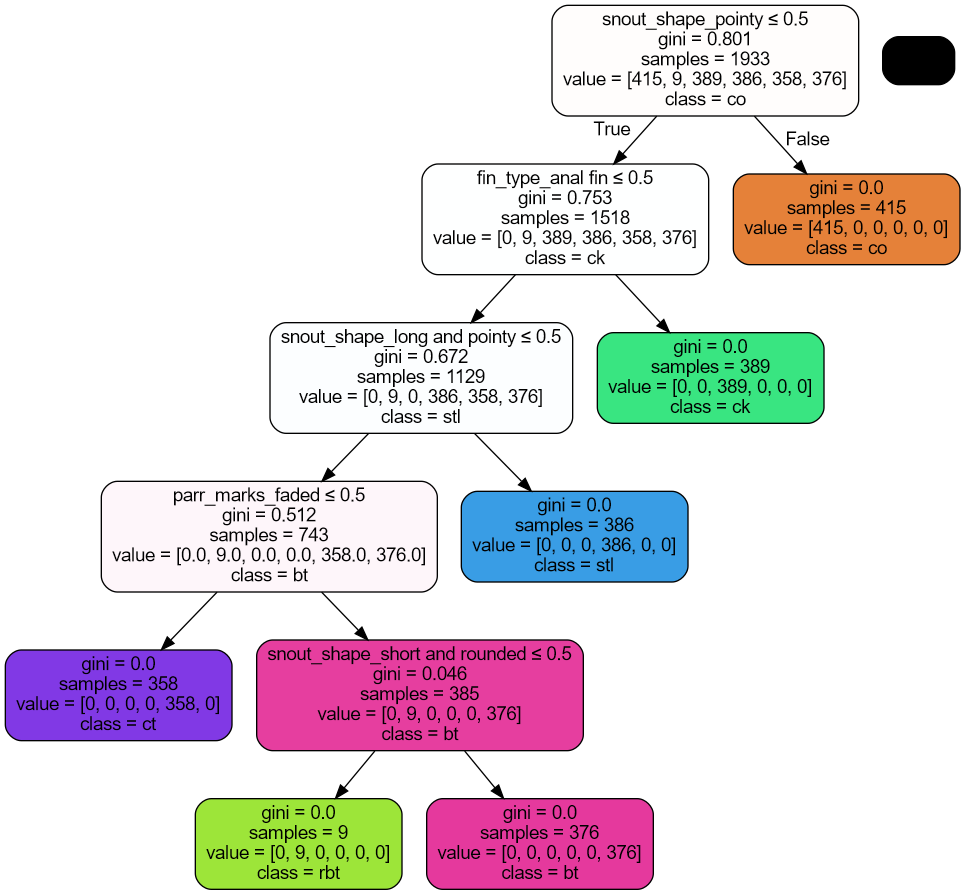

In [30]:
dot_data = StringIO()
export_graphviz(decision_tree, out_file = dot_data, filled = True, 
                rounded = True, 
                special_characters = True,
                feature_names = column_names,
                class_names = ["co", "rbt", "ck", "stl", "ct", "bt", "cm"], max_depth = 20)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png("Decision_tree.png")
Image(graph.create_png())

In [31]:
print("Test score: ", decision_tree.score(X_test, y_test))

Test score:  1.0


In [32]:
y_pred = decision_tree.predict(X_test)

In [33]:
y_pred[:5]

array(['co', 'co', 'stl', 'rbt', 'ct'], dtype=object)

In [34]:
import pickle
pickle.dump(decision_tree, open('model/dt_riya.h5', 'wb'))